# Python notebook about evaluation of automatic image segmentation:

Let's consider an image segmentation problem on just a couple slices of a CT , apply different segmentation algorithms, then compare the algorithms in a quantitative manner.

We will quantify the performance of the segmentation methods in one particular way. We will simplify here down to two classes of pixels: pixels belonging to the background and pixels belonging to the organ interest- the bone in this case.

In order to understand some different segmentation methods, we are going to use two different images I found on Radiopaedia I have made to show bone segmentation:

- **Training image** ('train.jpg'): The one we are using in order to design the sementation method
- **Test iamge** ('test.jpg'): The image we are going to use in order to test the previously designed segmentation approach

For each of the images we also have their corresponding ground truth segmentation images obtained from me drawing segmentation by hand('train_gt.png' and 'test_gt.png'). We will use them as reference in order to quantify the performance of the sementation method. First we take a look to the image dataset: 

 First we take a look to the image dataset: to do this you need the images in the right place- and of course these images are CC images, case courtesy of Dr David van Gelderen, Radiopaedia.org, rID: 37030

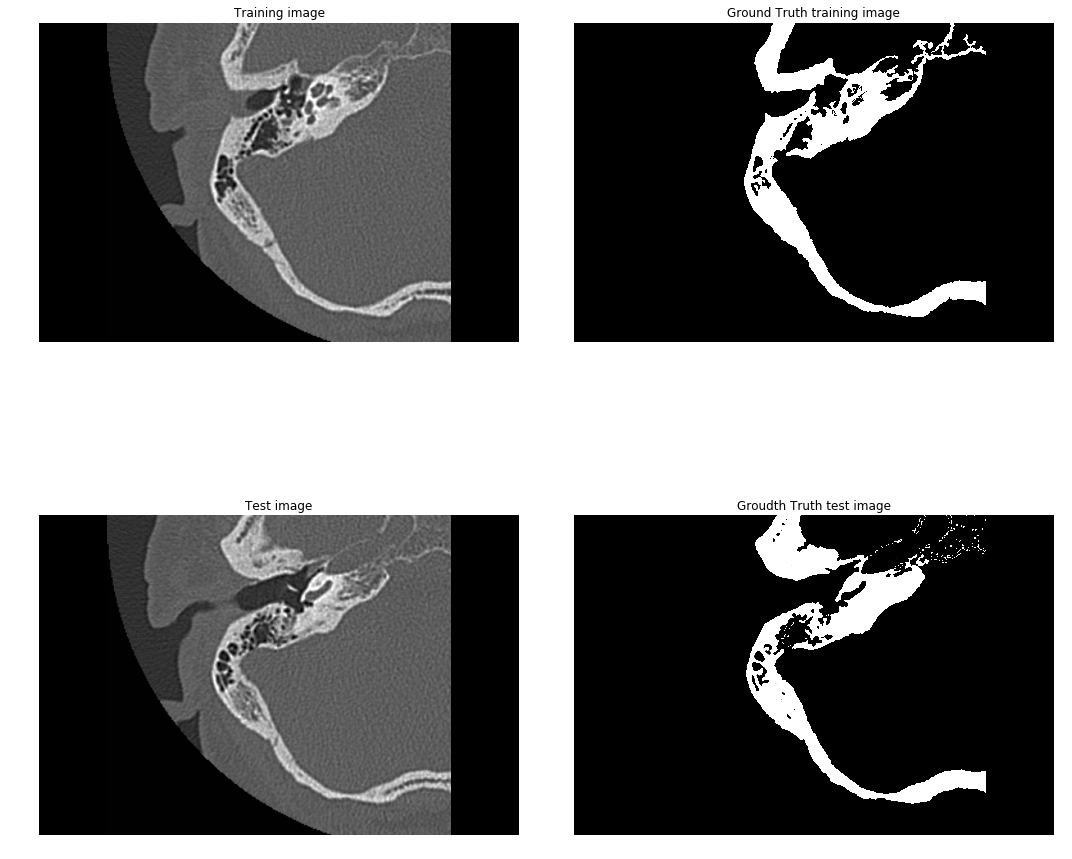

In [18]:
from skimage import io as skio
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np

I_train = skio.imread("train1.jpg") 
I_train_GT = skio.imread('train1_gt.png') 
I_test = skio.imread('test1.jpg') 
I_test_GT = skio.imread('test1_gt.png')

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(2, 2)

ax0 = fig.add_subplot(gs[0,0])
ax0.imshow(I_train, cmap=plt.cm.gray)
ax0.set_title('Training image')
ax0.set_axis_off()

ax1 = fig.add_subplot(gs[0,1])
ax1.imshow(I_train_GT, cmap=plt.cm.gray)
ax1.set_title('Ground Truth training image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[1,0])
ax2.imshow(I_test, cmap=plt.cm.gray)
ax2.set_title('Test image')
ax2.set_axis_off()

ax3 = fig.add_subplot(gs[1,1])
ax3.imshow(I_test_GT, cmap=plt.cm.gray)
ax3.set_title('Groudth Truth test image')
ax3.set_axis_off()

plt.tight_layout()
plt.show()

# Preset thresholding:

A straightforward segmentation approach would be setting a manual grayscale trheshold after inspection of the image histogram. This is an example of a possible segementation algorithm.

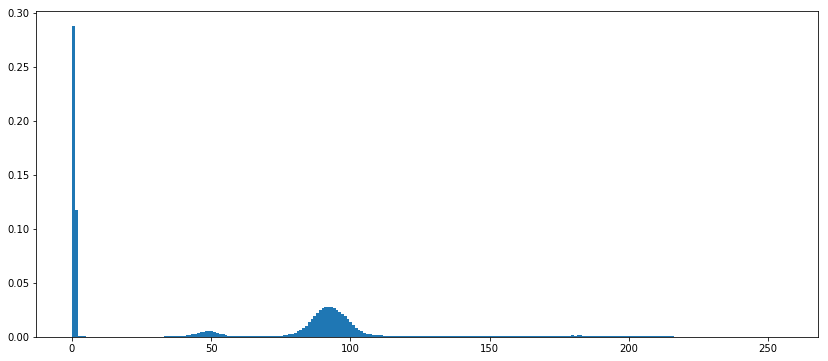

In [19]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

# reshape training image as 1d array:
v_I_train = I_train.reshape(I_train.shape[0]*I_train.shape[1],1).astype(np.uint8) 

fig = plt.figure(figsize=(14, 6))
plt.hist(v_I_train, bins=256,density=True)
plt.show()

###### Since we observe two clear clusters in the histogram we can separate them using a threshold. To do this in a way that highlights the point of this notebook let's set that at  160/ Note this is not Hounsefeld units rather arbitrary units from 0 to 256 made when the image was transformed into a .jpg file:

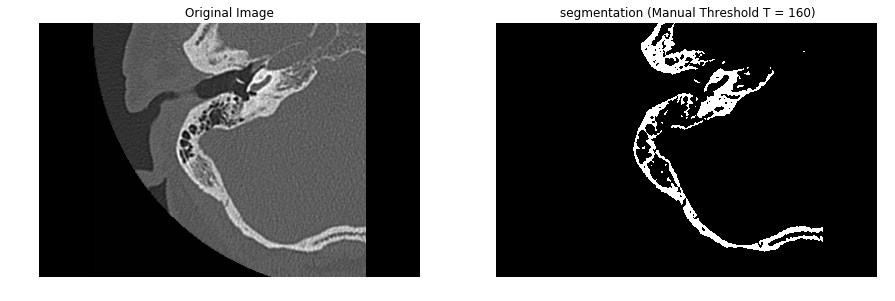

In [20]:
# Find Otsu's threshold for training image:
threshold_manual = 160

# Apply manual threshold to test image (Image Binarization):
I_manual = I_test >= threshold_manual


fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I_test, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_manual, cmap=plt.cm.gray)
ax2.set_title(' segmentation (Manual Threshold T = {})'.format(threshold_manual))
ax2.set_axis_off()

plt.show()

## Otsu's Algorithm:

One automatic segmentation approach is the Otsu's Method. In this case it does not work so well, but provides a good example for us to experiment with. 

The algorithm finds the threshold that **maximum inter-class variance** $\sigma _{b}^{2}(t)$, defined in terms of the difference between the means of the two clusters in the image histogram (pattern and background, respectively):

$\sigma _{b}^{2}(t)=\omega _{0}(t)\omega _{1}(t)\left[\mu _{0}(t)-\mu _{1}(t)\right]^{2}$ 

The algorithm is the following: 

1. Compute histogram and probabilities of each intensity level $p(i), i=0,\dots L$ where $L=2^n$ for an n-bit grayscale image.

2. Set up initial $\omega _{i}(0)$ and $\mu _{i}(0)$ 

3. Step through all possible thresholds $t=1,\ldots L-1$ 

a) Update $\omega _{i}$ and $\mu _{i}$


$\omega _{0}(t)=\sum _{i=0}^{t-1}p(i)$

$\omega _{1}(t)=\sum _{i=t}^{L-1}p(i)$

$\mu _{0}(t)={\frac {\sum _{i=0}^{t-1}ip(i)}{\omega _{0}(t)}}$

$\mu _{1}(t)={\frac {\sum _{i=t}^{L-1}ip(i)}{\omega _{1}(t)}}$

b) Compute $\sigma _{b}^{2}(t)=\omega _{0}(t)\omega _{1}(t)\left[\mu _{0}(t)-\mu _{1}(t)\right]^{2}$ 

4. Desired threshold corresponds to the maximum inter-class variance $\sigma _{b}^{2}(t)$ 

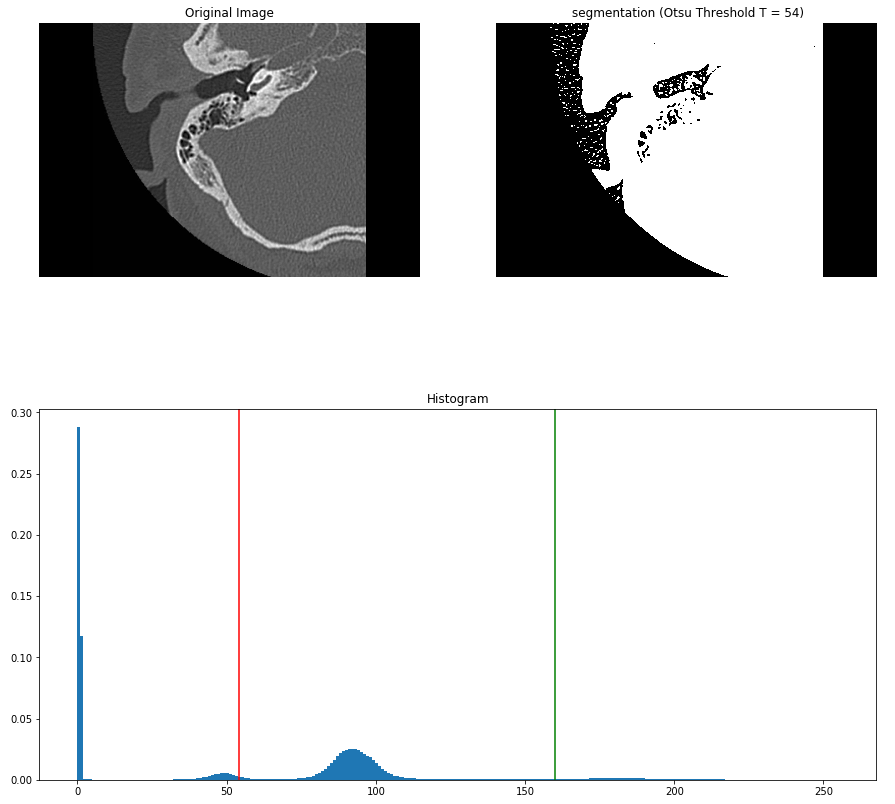

In [21]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
from skimage.filters import threshold_otsu

# Find Otsu's threshold for training image:
threshold_otsu = threshold_otsu(I_train)

# Apply threshold to test image:
I_otsu = I_test >= threshold_otsu

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(2, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I_test, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_otsu, cmap=plt.cm.gray)
ax2.set_title(' segmentation (Otsu Threshold T = {})'.format(threshold_otsu))
ax2.set_axis_off()

ax3 = fig.add_subplot(gs[1,:])
ax3.hist(I_test.ravel(), bins=256,density=True)
ax3.axvline(threshold_otsu, color='r')
ax3.axvline(threshold_manual, color='g')
ax3.set_title('Histogram')
plt.show()

Looks like where (the numbers) we set the Otsu method was a nearly total fail (it picked up bone and soft tissue). We can all see a simple threshold did better here- but let's look into the mathematics. Just FYI most segmentation methods will like use some thing more sophisticated in terms of an algorithm. 

Some common simple segmentation algorithms ones are  based on unsupervised AI, like the following: 

- Kmeans clustering
- Hierarchical clustering
- Gaussian Mixture models



## kmeans algorithm:

[1] Specify the number of clusters $k$ to be found in data.

[2] Set initial values for the cluster centroids $\mu^0_1,\dots,\mu^0_k$ (at random or prior knowledge). 

[3] Assign each observation to the nearest cluster (euclidean distance).

[4] Recompute the centroid of each cluster from the assigned observations $\mu^1_1,\dots,\mu^1_k$.

[5] Repeat steps 3-4 until no change in the centroids. Provide final clustering $\mu^n_1,\dots,\mu^n_k$, where $n$ is the number of iterations.

SUPER IMPORTANT: if you have a slow computer like my lap top it may take five minutes to get the KMeans algorithm to run. WAIT until you see the picture to go to the next step. Also...you will notice when this algorithm is 'pure' in this case it gives very as resuts


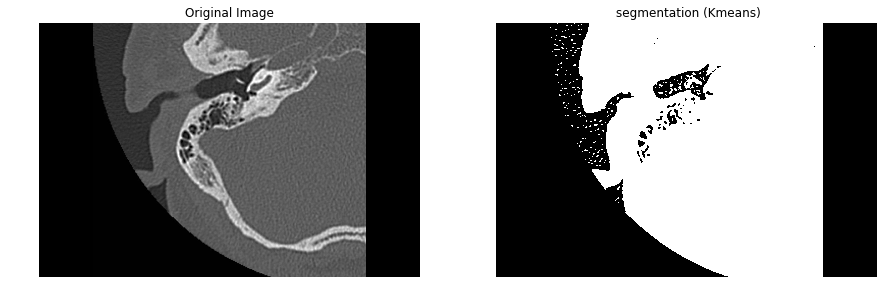

In [22]:
from sklearn.cluster import KMeans

# reshape training image as 1d array:
v_I_train = I_train.reshape(I_train.shape[0]*I_train.shape[1],1).astype(np.uint8) 

# Fit a Kmeans clustering model with two clusters using training image:
kmeans = KMeans(n_clusters=2, random_state=0).fit(v_I_train)

# Apply to predict test image:
v_I_test = I_test.reshape(I_test.shape[0]*I_test.shape[1],1).astype(np.uint8) # reshape image as 1d array

v_kmeans = kmeans.predict(v_I_test)
v_kmeans= np.logical_not(v_kmeans)
I_kmeans = np.array(v_kmeans).reshape(I_test.shape[0],I_test.shape[1]).astype(np.uint8) # Shape back result as image 


fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I_test, cmap=plt.cm.gray)
ax1.set_title('Original Image')
ax1.set_axis_off()

ax2 = fig.add_subplot(gs[0,1])
ax2.imshow(I_kmeans, cmap=plt.cm.gray)
ax2.set_title(' segmentation (Kmeans)')
ax2.set_axis_off()

plt.show()

WARNING: Make sure you have a result with pictures (should come out really bad in terms of segmentation) before running the next block of code. 
An explanation about the next block of code:
## Evaluating segmentation algorithms:

In order to evaluate a segmentation algorithm, we should introduce the following quantities:

- True positive (TP): A pattern pixel that has been correctly segmented as pattern
- True negative (TN): A background pixel that has been correctly segmented as background
- False positive (FP): A background pixel that has been mistakenly segmented as pattern (false alarm, Type I error)
- False negative (FN): A pattern pixel that has been mistakenly segmented as bavkground (omission, Type II error)

The confusion matrix is a 2x2 matrix reporting these four values: TP,TNFP,FN. 

From them we can define different measures of error: 

- Sensitivity, recall, hit rate, or true positive rate (TPR):

## $\text{TPR} =\frac{TP}{TP+FN}$

- Specificity, selectivity or true negative rate (TNR):

## $\text{TNR} =\frac{TN}{TN+FP}$

- The Sorensen-Dice similarity index: 

Measures the similarity between a segmentation mask and the ground truth mask by computing the F1 score
is the harmonic mean of precision and sensitivity:

$\text{DSC}={\frac {2TP}{2TP+FP+FN}}$.

Let's compute these magnitudes for each of the segmentation methods- and remember, you need all the cells above to have run to completion for this also slow computation to happen (give it 5 minutes):

Manual Segmentation: TPR=0.5575974279386035, FPR=0.00034905261964868065, DSC=0.7144378032021458
Otsu Segmentation: TPR=0.9990217793020388, FPR=0.4856455314653329, DSC=0.3004472332398294
Kmeans Segmentation: TPR=0.9989455375303352, FPR=0.48276662317563673, DSC=0.30167854589503196


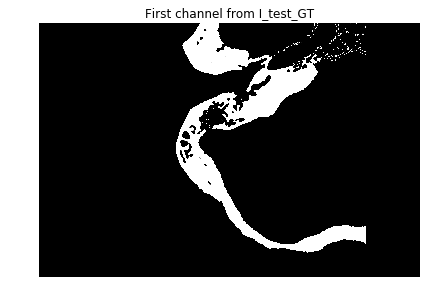

In [23]:
from sklearn.metrics import confusion_matrix

# I_test_GT_0 = I_test_GT[:, :, 0]

I_test_GT_0 = I_test_GT

fig = plt.figure(figsize=(15, 15))
gs = gridspec.GridSpec(1, 2)

ax1 = fig.add_subplot(gs[0,0])
ax1.imshow(I_test_GT_0, cmap=plt.cm.gray)
ax1.set_title('First channel from I_test_GT')
ax1.set_axis_off()

v_test_GT = I_test_GT_0.reshape((I_test_GT_0.shape[0]*I_test_GT_0.shape[1],1)).astype(np.bool) 

v_manual = I_manual.reshape(I_manual.shape[0]*I_manual.shape[1],1).astype(np.bool) 
CM_manual = confusion_matrix(v_test_GT,v_manual)
tn, fp, fn, tp = CM_manual.ravel()
TPR_manual = tp/(tp+fn)
FPR_manual = fp/(fp+tn)
DSC_manual = 2*tp/(2*tp+fp+fn)

v_otsu = I_otsu.reshape(I_otsu.shape[0]*I_otsu.shape[1],1).astype(np.bool) 
CM_otsu = confusion_matrix(v_test_GT,v_otsu)
tn, fp, fn, tp = CM_otsu.ravel()
TPR_otsu = tp/(tp+fn)
FPR_otsu = fp/(fp+tn)
DSC_otsu = 2*tp/(2*tp+fp+fn)

CM_kmeans = confusion_matrix(v_test_GT,np.array(v_kmeans).astype(np.bool))
tn, fp, fn, tp = CM_kmeans.ravel()
TPR_kmeans = tp/(tp+fn)
FPR_kmeans = fp/(fp+tn)
DSC_kmeans = 2*tp/(2*tp+fp+fn)

print('Manual Segmentation: TPR={}, FPR={}, DSC={}'.format(TPR_manual,FPR_manual,DSC_manual))
print('Otsu Segmentation: TPR={}, FPR={}, DSC={}'.format(TPR_otsu,FPR_otsu,DSC_otsu))
print('Kmeans Segmentation: TPR={}, FPR={}, DSC={}'.format(TPR_kmeans,FPR_kmeans,DSC_kmeans))

plt.show()

So there we have it...a mathematical look at segmentation algorithms. We can see the numbers make sense if we look back at the picutres. The Otsu's method has the highest true positive rate, but because it picks up too much Otsu's also has a high false positive rate. The highest false positive rate was in the K-means cluster (and the most dismally low true positive rate); a visual inspection proves this is logical.
In reality commercial algorithms are nether so bad nor so simplistic.

To make a program (essentially to reprogram this code above ) to evaluate commercial algorithms on 3D imaging takes time, but is not conceptually challenging...it's just a matter of code and linear algebra. That said, programming with actual DICOM files is extremely challenging, and takes a lot of skill.  

Further information: There are many ways to look at a segementation problem. Different commercial and open source algorithms can use many different aproaches. For example consider the Bayes theorem in the context of data classification:
\begin{equation*}
p(\omega_i|\vec{x}) = \frac{p(\vec{x}|\omega_i) p(\omega_i)}{p(\vec{x})}
\end{equation*}
where $\vec{x} = \{x_1,\dots,x_d\}$ is an observation in a d-dimensional feature space and $\omega_i$ is a label for class $i$. 
Bayesian decision theory: Assign observation $\vec{x}$ to the class that maximizes the posterior probability $p(\omega_i|\vec{x})$:
\begin{equation*}
\text{argmax}_{i \in 1,\dots,G} p(\omega_i|\vec{x}) 
\end{equation*}

We can define the discriminant function $g_i(\vec{x})$ as:
\begin{equation*}
g_i(\vec{x}) = \log p(\omega_i|\vec{x}) = \log p(\vec{x}|\omega_i) + \log p(\omega_i)
\end{equation*}



We can train models based on this with the sklearn.discriminant_analysis module...but this is not the point. We want, in reality, to evalute different models already made (I think). For this we can easily use Python code as outlined above. Just as there are many ways to segment- there are many ways to evaluate segmentation. Dice Sorenson co-efficient is only one of many already used possible methods. For further information, see my research proposal.

Note: you can easily change the thresholds here, but if you want to substitute your own pictures and segmentations you need to be extremely careful about the dimensions of them in terms of linear algebra operations. In short, if you are not used to both linear algebra and coding in the Python language, you will probably just make a mess. Just ask me instead. Dr. Candace Makeda Moore, MD